## Question 2: Animal classification (15 marks) {-}

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules: {-}

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2024
### Student Name: Robin Viltoriano
### Student ID: a1900159
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 0.9346        FLOPs: 0.11
##################################################################################################################################

In [1]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pandas as pd

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset
from torchvision import transforms

# Load Data

In this step the data transformation function is changed since we do not want to augment the validation and testing dataset. Thus, the transformation is done after the data splitting

In [ ]:
# # Mounting G-Drive to get your dataset.
# # To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# # Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/CV/animal/dataset/dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

test_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.488], std=[0.2172]),
        ])

dataset = ImageFolder(data_dir)


Dataset description:

In [4]:
# Random Splitting.
torch.manual_seed(42)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
# len(train_ds), len(val_ds), len(test_ds)
print(f"{train_size=}")
print(f"{val_size=}")
print(f"{test_size=}")

train_size=5330
val_size=313
test_size=627


In [5]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)

# Apply transformations
train_ds = TransformedDataset(train_ds, transform = train_transform)
val_ds = TransformedDataset(val_ds, transform = test_transform)
test_ds = TransformedDataset(test_ds, transform = test_transform)

In [6]:
batch_size = 2**4
print(f"{batch_size=}")
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=0, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=0, shuffle=False, pin_memory=True)

batch_size=16


In [7]:
# Viewing one of images shape.
print('Image Shape')
img, label = train_ds[200]
print(img.shape)

Image Shape
torch.Size([3, 112, 112])


In [8]:
# Preview one of the images..
def show_image(data):
    print('Label: ', data[1])
    plt.imshow(data[0].permute(1,2,0))

Label:  69


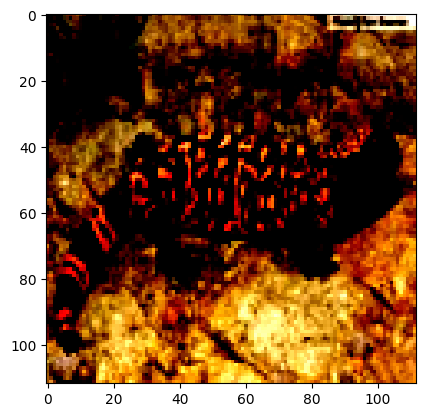

In [9]:
show_image(train_ds[200])

# Utilities
This are the functions that will be used througout the entire notebook

In [10]:
import os
os.chdir('/content/drive/MyDrive/CV')

from FLOPs_counter import print_model_parm_flops

In [11]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
print(f'Device use: {device}')

Device use: cuda


In [32]:
def save_history(list_variable, file_path):
  with open(file_path, 'w') as f:
    for item in list_variable:
        f.write("%s\n" % item)

# Preprocess Data

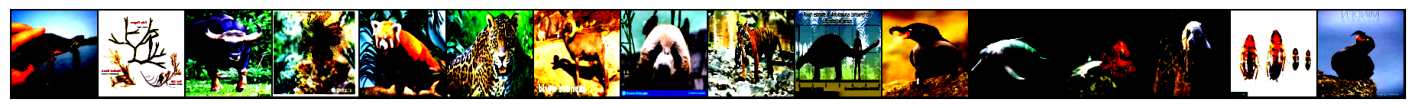

In [13]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# Model

In this part, the baseline model will be trained and evaluated. Furthermore, some improvements for the baseline model, such as adding batch normalization layers, dropout layer, and optimizing learning rate will also be implemented.

The model will be trained using 20 epochs and use 1e-3 learning rate with Adam optimizer.


In [14]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
input_size = 3*112*112
output_size = 151

In [17]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)

    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

# Convolutional Network - Baseline with Batch Normalization
class ConvolutionalNetworkBN(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.bn1= nn.BatchNorm2d(64)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.bn2= nn.BatchNorm2d(128)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,1000)
        self.fc2 = nn.Linear(1000,self.num_classes)

    def forward(self,X):
        X=F.relu(self.bn1(self.conv1(X)))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.bn2(self.conv2(X)))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.bn2(self.conv3(X)))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.bn2(self.conv4(X)))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        X=self.fc2(X)

        return F.log_softmax(X, dim=1)

# Convolutional Network - Baseline with Dropout Layer
class ConvolutionalNetworkDP(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,1000)
        self.dp1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1000,self.num_classes)

    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        X=self.dp1(X)
        X=self.fc2(X)

        return F.log_softmax(X, dim=1)

# Convolutional Network - Baseline with Batch Normalization and Dropout layer
class ConvolutionalNetworkBN_DP(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.bn1= nn.BatchNorm2d(64)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.bn2= nn.BatchNorm2d(128)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,1000)
        self.dp1=nn.Dropout(0.2)
        self.fc2 = nn.Linear(1000,self.num_classes)

    def forward(self,X):
        X=F.relu(self.bn1(self.conv1(X)))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.bn2(self.conv2(X)))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.bn2(self.conv3(X)))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.bn2(self.conv4(X)))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        X=self.dp1(X)
        X=self.fc2(X)

        return F.log_softmax(X, dim=1)

## Baseline Model

In [19]:
# Model print
print('Baseline Model Architecture: \n')
num_classes = 151
model = ConvolutionalNetwork(num_classes).to(device)
print(model)

Baseline Model Architecture: 

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)


Function check to see whether the model is working properly

In [ ]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print(f"{labels=}")
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
labels=tensor([106, 108,  46,  24,  51, 150,  85,  46,  17,  12,  49,  27, 132,  94,
         63, 102], device='cuda:0')
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0226, -4.9644, -4.9786, -5.0700, -5.0700, -5.0794, -4.9602, -5.0197,
        -5.0600, -5.0252, -5.0978, -5.0477, -4.9549, -4.9854, -4.9991, -5.0307,
        -4.9736, -5.0687, -5.0210, -5.0679, -5.0232, -4.9974, -4.9263, -5.0346,
        -5.0167, -4.9964, -5.0233, -4.9612, -5.0412, -5.1252, -5.0569, -5.0222,
        -5.0188, -4.9974, -4.9706, -4.9856, -4.9753, -4.9983, -4.9720, -5.0071,
        -5.0747, -5.0138, -5.0474, -4.9716, -5.0123, -5.0479, -5.0702, -4.9944,
        -5.0110, -4.9622, -5.0204, -4.9814, -4.9948, -5.0312, -4.9974, -4.9611,
        -5.0326, -4.9971, -4.9811, -4.9725, -5.0814, -5.0312, -4.9931, -5.0397,
        -5.0757, -5.0131, -5.0405, -5.0416, -5.0197, -5.0380, -5.0206, -4.9821,
        -4.9972, -5.0426, -5.0352, -5.0354, -4.9785, -5.0026, -5.0285, -5.

As can be seen, since we use 16 batch so the first dimension of the input shape is 16. Furthermore, the output from the model is not a probabillity.

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [24]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history = []

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 20
lr = 1e-3
opt_func = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=0)

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

Baseline Model result:

In [ ]:
model_eval = evaluate(model, test_loader)
model_eval

{'val_loss': 10.633554458618164, 'val_acc': 0.3473958671092987}

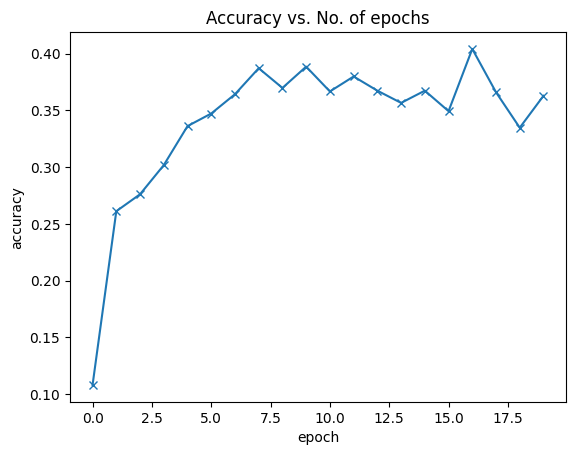

In [ ]:
plot_accuracies(history)

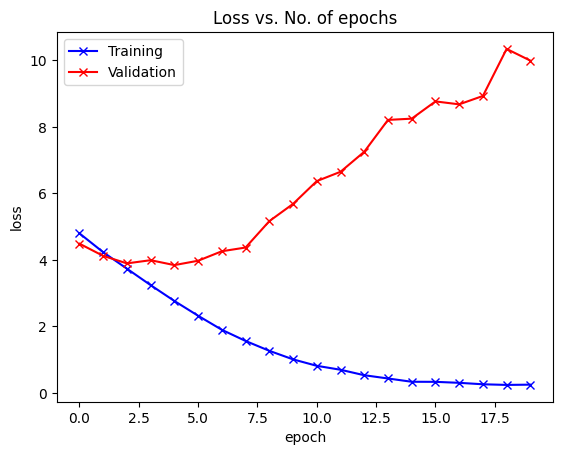

In [ ]:
plot_losses(history)

From the loss graph above, it is obvious that the baseline model is overfitting. The loss validation loss goes up after the third epoch.

The results above reflect the test dataset’s evaluation loss and accuracy score for the baseline model, despite being labeled as “validation.” The baseline model is used to predict the test dataset, establishing a baseline score for this experiment. However, when selecting the best model, only the validation dataset will be used to prevent bias in the test data.

As shown, the baseline model achieves only 35% accuracy, indicating that it is still underfitting.

### FLOPs

In [ ]:
# !git clone https://github.com/JJBOY/FLOPs.git

Calculating the number of FLOPs:

In [ ]:
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
flops = print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


In [ ]:
model_eff = model_eval['val_acc'] / flops
print(f'Base Model Efficiency: {model_eff:,.6f}')

Base Model Efficiency: 0.546779


In [ ]:
dict_eval = {}
dict_eval['Base Model'] = {
    'Accuracy': model_eval['val_acc'],
    'FLOPs': flops,
    'Efficiency': model_eff
}

df_evaluation = pd.DataFrame(dict_eval)
df_evaluation

,Base Model
Accuracy,0.377083
Efficiency,0.546779
FLOPs,0.689645


The baseline model has 0.69G number of FLOPs. This could be categorise as a light model. However, since the accuracy of the model is low, therefore the efficiency of the model is also low, which is 0.55.

In the next section, we will try to improve the model using batch normalization and dropout layer.

### Baseline + Batch Normalization

In this section, the batch normalization layer will be apply after each convolutional layer. Furthermore, one fully connected layer will be added after the last convolutional layer.

In [26]:
# Model print
print('Baseline Model with Batch Normalization Architecture: \n')
model_bn = ConvolutionalNetworkBN(num_classes).to(device)
model_bn = to_device(model_bn, device)
print(model_bn)

Baseline Model with Batch Normalization Architecture: 

ConvolutionalNetworkBN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=151, bias=True)
)


In [27]:
history_bn = []

In [28]:
# Hints: The following parameters can be changed to improve the accuracy
# print(test_size)
num_epochs = 20
lr = 1e-4
opt_func = torch.optim.Adam(model_bn.parameters(), lr = lr, weight_decay=0)

In [ ]:
history_bn += fit(num_epochs, lr, model_bn, train_dl, val_dl, opt_func)

Model with batch normalization result:

In [111]:
model_eval = evaluate(model_bn, val_dl)
model_eval

{'val_loss': 5.861218452453613, 'val_acc': 0.19861112534999847}

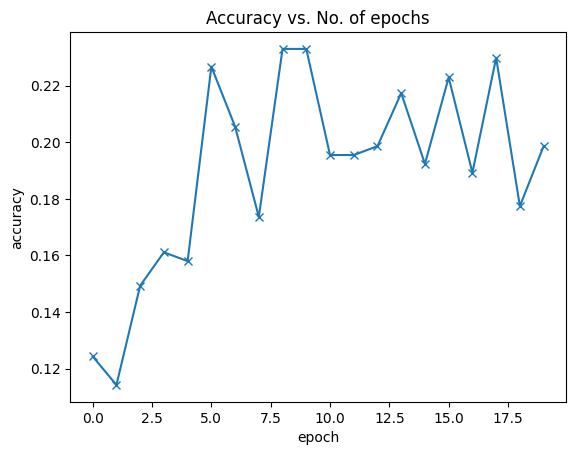

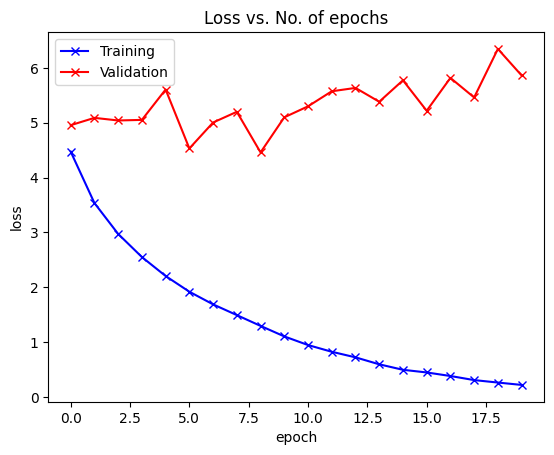

In [34]:
plot_accuracies(history_bn)
plot_losses(history_bn)

The baseline model with batch normalization perform poorly compare to the original baseline model. The model is still overfitt, indicates by the validation loss from the graph above. The validation loss curve keep getting higher as the epochs go up. Additionally, the validation accuracy curve is also fluctuating over time. This means by adding a batch normalization layer, the it needs less learning rate to prevent fluctuation.

### Baseline + Dropout

The dropout layer with probability = 0.2 is added to the baseline model. One fully connected layer was also added in the architecture

In [36]:
# Model print
print('Baseline Model with Dropout Architecture: \n')
model_dp = ConvolutionalNetworkDP(num_classes).to(device)
model_dp = to_device(model_dp, device)
print(model_dp)

Baseline Model with Dropout Architecture: 

ConvolutionalNetworkDP(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=1000, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1000, out_features=151, bias=True)
)


In [37]:
history_dp = []

In [38]:
# Hints: The following parameters can be changed to improve the accuracy
num_epochs = 20
lr = 1e-3
opt_func = torch.optim.Adam(model_dp.parameters(), lr = lr, weight_decay=0)

In [ ]:
history_dp += fit(num_epochs, lr, model_dp, train_dl, val_dl, opt_func)

Model with dropout layer result:

In [44]:
evaluate(model_dp, val_dl)

{'val_loss': 5.593988418579102, 'val_acc': 0.3048611283302307}

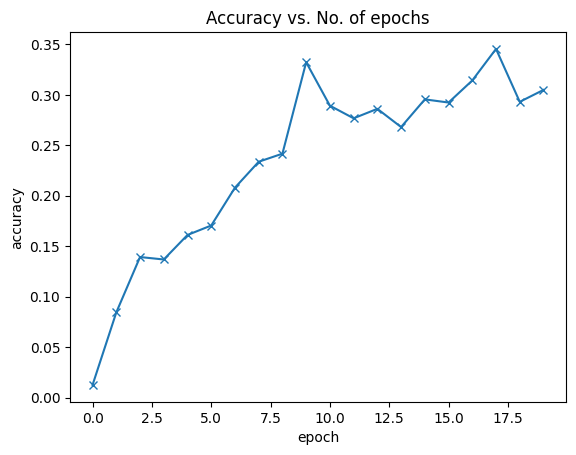

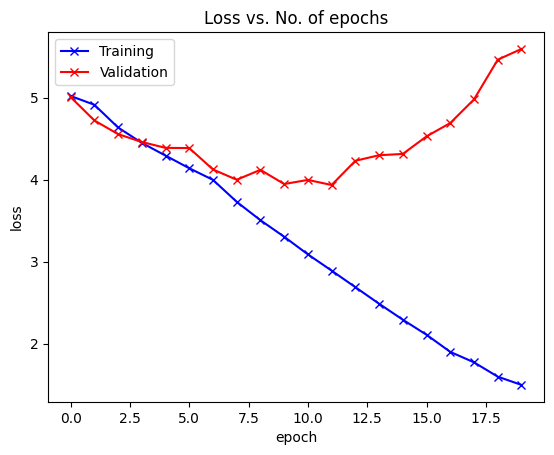

In [43]:
plot_accuracies(history_dp)
plot_losses(history_dp)

Even though the dropout layer has been introduce, the model still has an overfitt problem. This could be seen in the validation loss curve above. This model performs better than the baseline + batch normalization model, however still performs worst than the default baseline model.

### Baseline + Batch Normalization + Dropout

In this section, the batch normalization after each convolutional layer as well as the dropout layer are added to the baseline model architecture. We want to see whether these two additional layers could made the model not overfitting.

Below is the model architecture:

In [45]:
# Model print
model_bn_dp = ConvolutionalNetworkBN_DP(num_classes).to(device)
model_bn_dp = to_device(model_bn_dp, device)
print(model_bn_dp)

ConvolutionalNetworkBN_DP(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=1000, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1000, out_features=151, bias=True)
)


In [46]:
history_bn_dp = []

In [47]:
# Hints: The following parameters can be changed to improve the accuracy
num_epochs = 20
lr = 1e-3
opt_func = torch.optim.Adam(model_bn_dp.parameters(), lr = lr, weight_decay=0)

In [ ]:
history_bn_dp += fit(num_epochs, lr, model_bn_dp, train_dl, val_dl, opt_func)

Model with batch normalization and dropout layer result:

In [50]:
evaluate(model_bn_dp, val_dl)

{'val_loss': 10.75321102142334, 'val_acc': 0.11736112087965012}

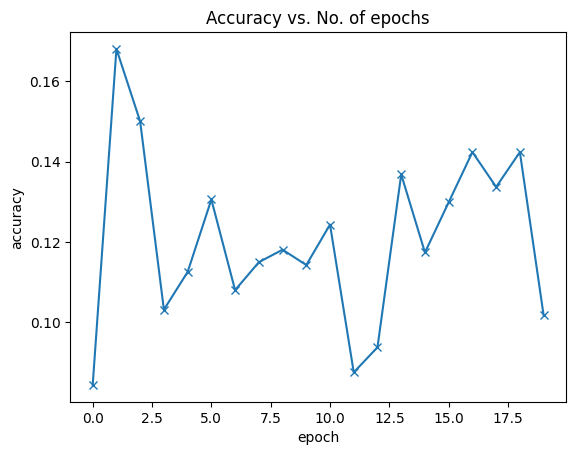

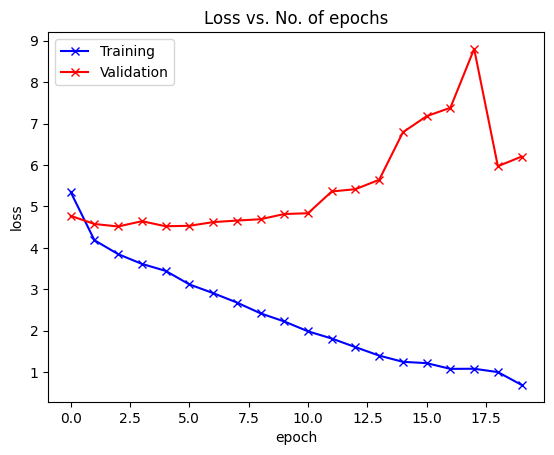

In [ ]:
plot_accuracies(history_bn_dp)
plot_losses(history_bn_dp)

As observed above, not only the model is still overfitting, but also it perform worst than the default baseline model. This can be concluded that the batch normalization layer is not suitable for the dataset and the current architechture.

In the next section we will implement data augmentation by introducing random flipping, rotation, grey scale, affine transformation and color brightness changes.

# Improvement

In this section, the data will not be cropped, thus the image size is still 224x224. The reason is that we want the model to capture more information from the images.

In [51]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torchvision import models
import torch.nn as nn


In [ ]:
train_transform_imp = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),        # Randomly crop and resize to 224x224
            transforms.RandomHorizontalFlip(),         # Randomly flip the image horizontally
            transforms.RandomRotation(15),             # Randomly rotate the image by 15 degrees
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Randomly change the brightness, contrast, saturation, and hue
            transforms.RandomVerticalFlip(),           # Randomly flip the image vertically
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Randomly translate the image
            transforms.RandomGrayscale(p=0.2),         # Randomly convert the image to grayscale with a probability of 20%
            transforms.ToTensor(),                     # Convert the image to a tensor
            transforms.Normalize(mean=[0.488], std=[0.2172]), # Normalize the image
        ])

test_transform_imp = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.488], std=[0.2172]),
        ])

dataset_imp = ImageFolder(data_dir)

# Random Splitting.
torch.manual_seed(42)
val_size = len(dataset_imp)//20
test_size = len(dataset_imp)//10
train_size = len(dataset_imp) - val_size - test_size

train_ds_imp, val_ds_imp, test_ds_imp = random_split(dataset_imp, [train_size, val_size, test_size])
len(train_ds_imp), len(val_ds_imp), len(test_ds_imp)

In [ ]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)

# Apply transformations
train_ds_imp = TransformedDataset(train_ds_imp, transform = train_transform_imp)
val_ds_imp = TransformedDataset(val_ds_imp, transform = test_transform_imp)
test_ds_imp = TransformedDataset(test_ds_imp, transform = test_transform_imp)

len(train_ds_imp), len(val_ds_imp), len(test_ds_imp)

The batch size will also be increase from 16 to 128. The reason is to reduce the training noice thus the model has smoother gradient during training. This method is assume could increase the model performance.

In [54]:
batch_size = 2**7
print(f"{batch_size=}")
train_loader_imp = DataLoader(train_ds_imp, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_imp = DataLoader(val_ds_imp, batch_size, num_workers=2, shuffle=False, pin_memory=True)
test_loader_imp = DataLoader(test_ds_imp, batch_size, num_workers=2, shuffle=False, pin_memory=True)

train_loader_imp = DeviceDataLoader(train_loader_imp, device)
val_loader_imp = DeviceDataLoader(val_loader_imp, device)
test_loader_imp = DeviceDataLoader(test_loader_imp, device)

batch_size=128


## General Function

Below are some general function that will be used during the model improvement

In [55]:
def fit_2(epochs, model, train_loader, val_loader,
          opt_func=torch.optim.SGD, scheduler = None,
          l2_lambda=None):
    history = []
    optimizer = opt_func
    criterion = torch.nn.CrossEntropyLoss()  # Loss function for classification

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            images, labels = images, labels

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_losses.append(loss.item())

            # Use Regularization
            if l2_lambda is not None:
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters() if p.requires_grad)
                loss += l2_lambda * l2_norm

            # Backward pass and optimization

            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Use LR Scheduler other than OneCycleLR
        if scheduler is not None:
          if type(scheduler).__name__ != 'OneCycleLR':
            scheduler.step()

        train_loss = sum(train_losses) / len(train_losses)
        train_acc = correct_train / total_train

        val_eval = evaluate_2(model, val_loader)
        val_loss = val_eval['val_loss']
        val_acc = val_eval['val_acc']

        # Log results
        result = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if scheduler is not None:
          print(f"LR: {scheduler.get_last_lr()}")

        history.append(result)

    return history

def evaluate_2(model, val_loader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()  # Loss function for classification
    val_losses = []
    total_val = 0
    correct_top3 = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images, labels
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            # Calculate top-3 accuracy
            top3_pred = torch.topk(outputs, 3, dim=1).indices
            correct_top3 += (top3_pred == labels.view(-1, 1)).sum().item()

            total_val += labels.size(0)

    val_loss = sum(val_losses) / len(val_losses)
    val_acc = correct_top3 / total_val

    print(f"Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return {
        'val_loss': val_loss,
        'val_acc': val_acc
    }


In [56]:
def plot_losses_2(history):
  df_eval = pd.DataFrame(history)

  plt.plot(df_eval['train_loss'], '-bx')
  plt.plot(df_eval['val_loss'], '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')
  plt.show()

def plot_accuracies_2(history):
  df_eval = pd.DataFrame(history)

  plt.plot(df_eval['train_acc'], '-bx')
  plt.plot(df_eval['val_acc'], '-rx')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy vs. No. of epochs')
  plt.show()

In [57]:
def test_model(model, data, pprint=True):
    try:
        # We can check the input and the output shape
        for images, labels in data:
            out = model(images)
            if pprint:
                print('images.shape:', images.shape)
                print(f"{labels=}")
                print('out.shape:', out.shape)
                print('out[0]:', out[0])
                print(f"{len(out[0])=}")
                print(f'output sum {sum(out[0])}')
            break
        print('Model Test: Passed')

    except Exception as e:
        print(f"Error: {e}")

In [58]:
def efficiency_test(model, data_loader, evaluate=True):
  input = to_device(torch.randn(1, 3, 224, 224), device) # The input size should be the same as the size that you put into your model
  #Get the network and its FLOPs
  flops = print_model_parm_flops(model, input, detail=False)

  if evaluate:
    model_eval = evaluate_2(model, data_loader)
    model_eff = model_eval['val_acc'] / flops.item()
    return model_eval, flops, model_eff

# Transfer Learning

In this section, transfer learning methods will be explored by comparing two pre-trained models: ResNet18 and MobileNetV3. Additionally, the performance of two optimizers, Adam and NAdam, will be tested. An Exponential Learning Rate Scheduler will also be evaluated.

All models will be trained for 20 epochs with a learning rate of 5e-4 and a weight decay parameter of 1e-3, unless otherwise specified.

## ResNet 18

The weight from IMAGENET_V1 is used for this model.

In [59]:
class ResNet18(nn.Module):
    def __init__(self, num_classes, freeze_layers = False):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        num_of_in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_of_in_features, num_classes)

        if freeze_layers:
          # Freeze all layers except the last fully connected layer
          for param in self.model.parameters():
              param.requires_grad = False
          for param in self.model.fc.parameters():
              param.requires_grad = True

    def forward(self, x):
        return self.model(x)


### Adam

In [ ]:
model_restnet18 = ResNet18(151, freeze_layers = False)
model_restnet18 = to_device(model_restnet18, device)

In [61]:
history_18=[]

In [62]:
num_epochs = 20
lr = 5e-4
opt_func = torch.optim.Adam(model_restnet18.parameters(), lr=lr, weight_decay=1e-3)

In [ ]:
history_18 += fit_2(epochs=num_epochs, model=model_restnet18,
                                     train_loader=train_loader_imp, val_loader=val_loader_imp,
                                     opt_func=opt_func)

Model result:

In [66]:
model_eval = evaluate_2(model_restnet18, val_loader_imp)

Loss: 1.4156, Acc: 0.8307


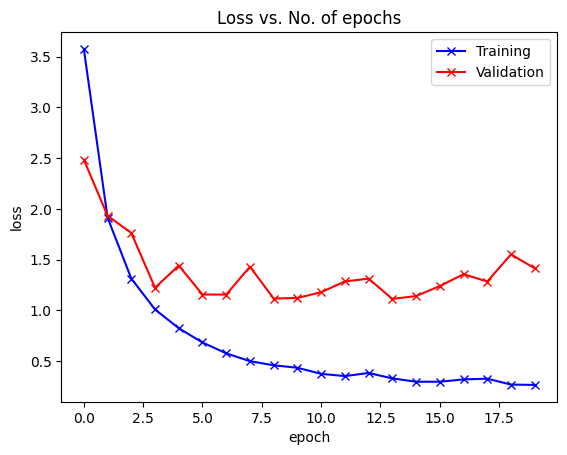

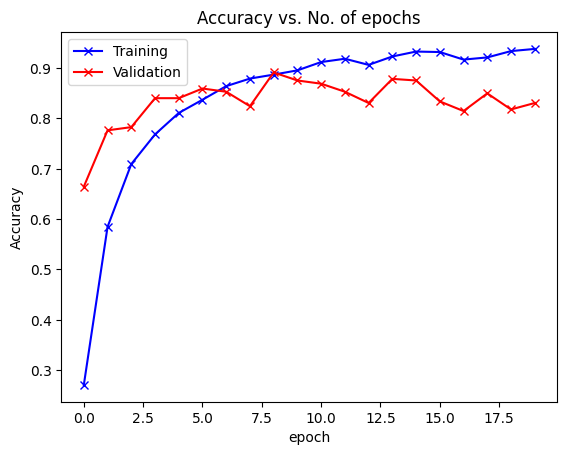

In [67]:
plot_losses_2(history_18)
plot_accuracies_2(history_18)

As observed, the model has an improvement compare to the baseline model. The accuracy is higer reaching 82%. The model is not as overfitt as the baseline model, as indicated from the loss curve.

### Nadam

In [68]:
model_restnet18_nadam = ResNet18(151, freeze_layers = False)
model_restnet18_nadam = to_device(model_restnet18_nadam, device)

In [69]:
num_epochs = 20
lr = 5e-4
opt_func = torch.optim.NAdam(model_restnet18_nadam.parameters(), lr=lr, weight_decay=1e-3)

In [70]:
history_18_nadam = []

In [ ]:
history_18_nadam += fit_2(epochs=num_epochs, model=model_restnet18_nadam,
                                     train_loader=train_loader_imp, val_loader=val_loader_imp,
                                     opt_func=opt_func)

Model result:

In [ ]:
model_eval = evaluate_2(model_restnet18_nadam, val_loader_imp)

Loss: 1.3458, Acc: 0.8371


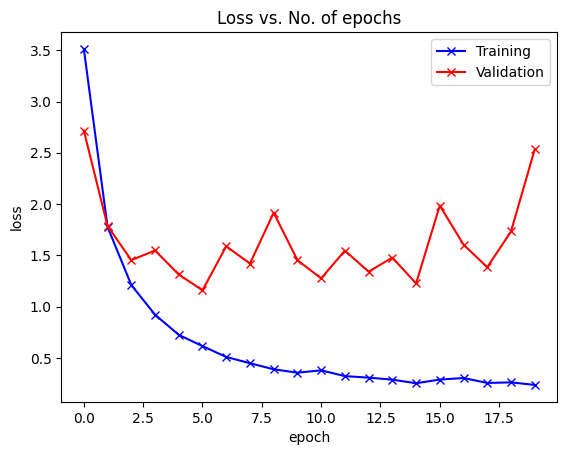

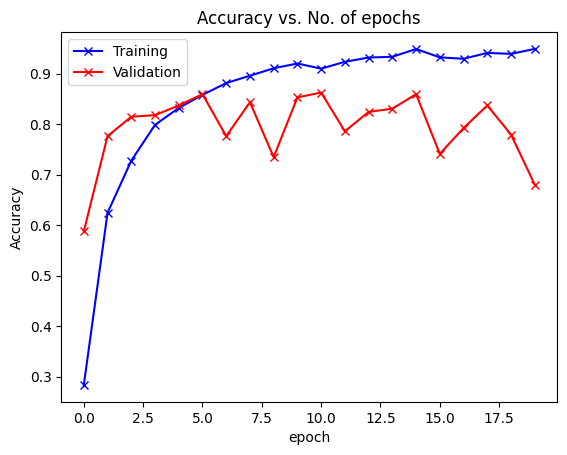

In [73]:
plot_losses_2(history_18_nadam)
plot_accuracies_2(history_18_nadam)

The NAdam optimizer result in more fluctuate loss curve. This means the model is more overfitt compared to the model with Adam optimizer.

### Weight Freeze
In this section, the weight of the model will be freezed, except the last classifier layer. The model will be trained using 20 epochs with Adam optimizer 5e-4 learning rate and 1e-3 weight decay parameter.

In [92]:
model_restnet18_freeze = ResNet18(151, freeze_layers = True)
model_restnet18_freeze = to_device(model_restnet18_freeze, device)

In [93]:
history_18_freeze=[]

In [94]:
num_epochs = 20
lr = 5e-4
opt_func = torch.optim.Adam(model_restnet18_freeze.parameters(), lr=lr, weight_decay=1e-3)

In [ ]:
history_18_freeze += fit_2(epochs=num_epochs, model=model_restnet18_freeze,
                                     train_loader=train_loader_imp, val_loader=val_loader_imp,
                                     opt_func=opt_func)

Model result:

In [101]:
model_eval = evaluate_2(model_restnet18_freeze, val_loader_imp)

Loss: 1.0422, Acc: 0.9042


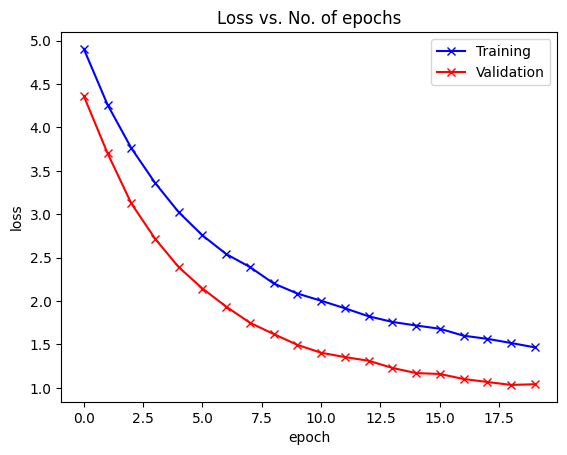

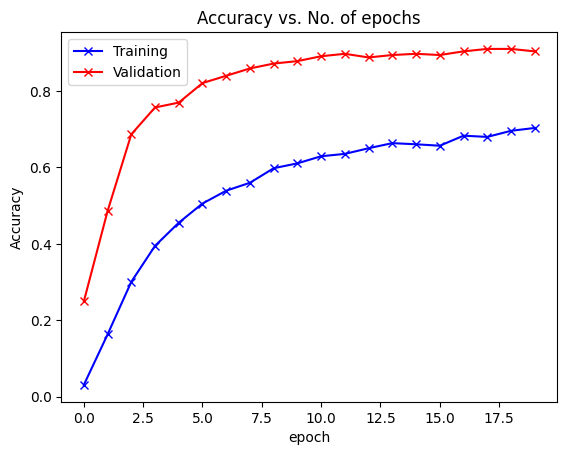

In [100]:
plot_losses_2(history_18_freeze)
plot_accuracies_2(history_18_freeze)

So far, this is the best model that has been trained. The model has 90% validation accuracy. However, from the graphs above we could see that the training loss curve is still higher than the validation loss curve. This means the model could still be trained further.

### LR Scheduler

In this method, adjustments are made to the model training process. For the first 10 epochs, the model weights will be frozen except for the last classifier layer, using a learning rate of 5e-3 with the Adam optimizer. For the subsequent 10 epochs, the pretrained model weights will be unfrozen, starting with a learning rate of 5e-4 and employing an Exponential Learning Rate Scheduler with a gamma of 0.8.

In [ ]:
model_restnet18_lr = ResNet18(151, freeze_layers = True)
model_restnet18_lr = to_device(model_restnet18_lr, device)

In [ ]:
history_18_lr=[]

In [ ]:
num_epochs = 10
lr = 5e-3
opt_func = torch.optim.Adam(model_restnet18_lr.parameters(), lr=lr, weight_decay=0)

In [ ]:
history_18_lr += fit_2(epochs=num_epochs, model=model_restnet18_lr,
                                     train_loader=train_loader_imp, val_loader=val_loader_imp,
                                     opt_func=opt_func)

In [ ]:
for param in model_restnet18_lr.model.parameters():
    param.requires_grad = True

In [ ]:
num_epochs = 10
lr = 5e-4
opt_func = torch.optim.Adam(model_restnet18_lr.parameters(), lr=lr, weight_decay=0)
for param_group in opt_func.param_groups:
    param_group['initial_lr'] = 5e-3
scheduler = lr_scheduler.ExponentialLR(opt_func, gamma=0.80, last_epoch=10)

In [ ]:
history_18_lr += fit_2(epochs=num_epochs, model=model_restnet18_lr,
                                     train_loader=train_loader_imp, val_loader=val_loader_imp,
                                     opt_func=opt_func, scheduler=scheduler)

Model Result:

In [91]:
restnet18_eval = efficiency_test(model_restnet18_lr, val_loader_imp)

 + Number of FLOPs: 3.59G
Loss: 0.5549, Acc: 0.9361


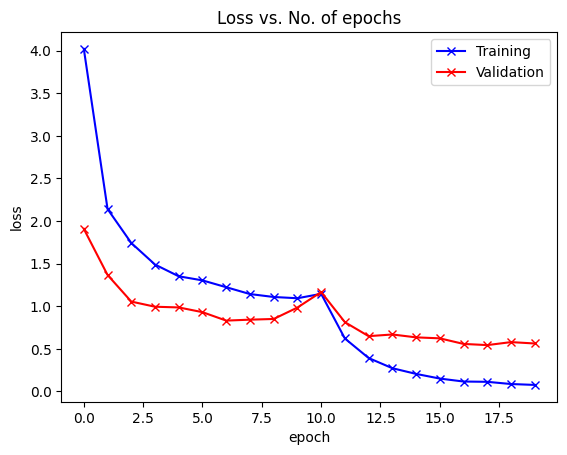

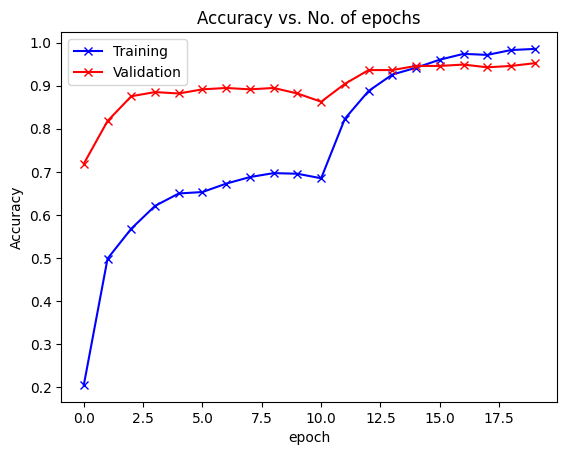

In [ ]:
plot_losses_2(history_18_lr)
plot_accuracies_2(history_18_lr)

This method resulted the best result for the ResNet18 experiments. The validation accuracy can reach 94%. There is an interesting pattern in the graphs above. From epoch 7 to 10 the model seems to become worst. However, when we change the method at epoch 11-20, the model performance increase significantly. This could be due to the lower learning rate and the learning rate scheduler that is used. Furthermore, since this is the best model for the ResNet18, the number of FLOPs is also calculated.

## MobileNetV3

This model is light and known to have a good performance, thus it will be choosen as the second transfer learning model. The weight from IMAGENET_V1 is used for this model.

In [74]:
class MobileNetV3(nn.Module):
    def __init__(self, num_classes, dropout=0.2, freeze_layers = True):
        super().__init__()
        self.model = models.mobilenet_v3_small(weights='IMAGENET1K_V1', dropout=dropout)
        num_in_feature = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(num_in_feature, num_classes)

        if freeze_layers:
          # Freeze all layers except the last fully connected layer
          for param in self.model.parameters():
              param.requires_grad = False
          for param in self.model.classifier.parameters():
              param.requires_grad = True

    def forward(self, x):
        return self.model(x)

### Adam

In [ ]:
model_mobilenetv3 = MobileNetV3(len(dataset_imp.classes), freeze_layers=False)
model_mobilenetv3 = to_device(model_mobilenetv3, device)

In [76]:
history_mobilenetv3=[]

In [77]:
num_epochs = 20
lr = 5e-4
opt_func = torch.optim.Adam(model_mobilenetv3.parameters(), lr=lr, weight_decay=1e-3)

In [ ]:
history_mobilenetv3 += fit_2(num_epochs, model_mobilenetv3,
                             train_loader_imp, val_loader_imp,
                             opt_func)

Model Result:

In [82]:
model_eval = evaluate_2(model_mobilenetv3, val_loader_imp)

Loss: 1.6858, Acc: 0.7508


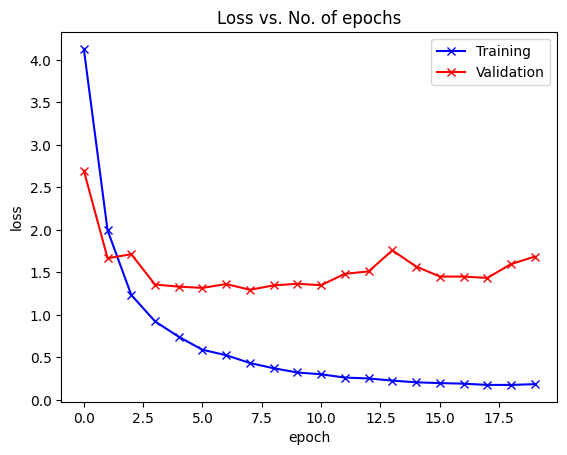

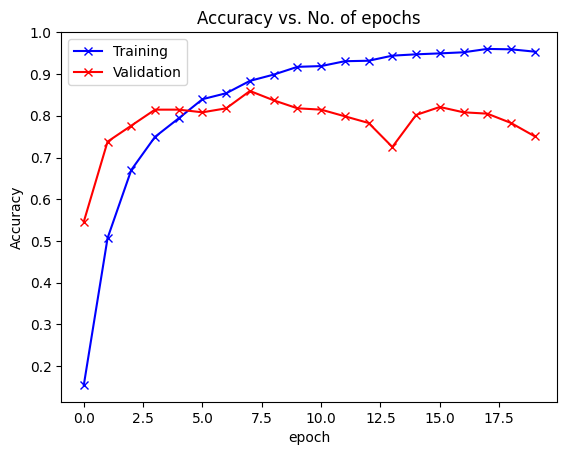

In [80]:
plot_losses_2(history_mobilenetv3)
plot_accuracies_2(history_mobilenetv3)

This model can perform better than the baseline model, which reaches 75% of accuracy. However, from the loss curve above, the model is getting worst over time. This means the model is overfitt.

### NAdam

In [83]:
model_mobilenetv3_nadam = MobileNetV3(len(dataset_imp.classes), freeze_layers=False)
model_mobilenetv3_nadam = to_device(model_mobilenetv3_nadam, device)

In [84]:
history_mobilenetv3_nadam=[]

In [85]:
num_epochs = 20
lr = 5e-4
opt_func = torch.optim.NAdam(model_mobilenetv3_nadam.parameters(), lr=lr, weight_decay=1e-3)

In [ ]:
history_mobilenetv3_nadam += fit_2(num_epochs, model_mobilenetv3_nadam,
                             train_loader_imp, val_loader_imp,
                             opt_func)

Model Result:

In [89]:
model_eval = evaluate_2(model_mobilenetv3_nadam, val_loader_imp)

Loss: 1.7958, Acc: 0.7412


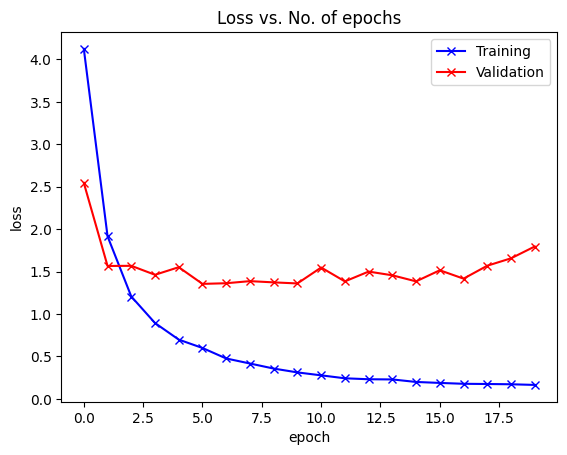

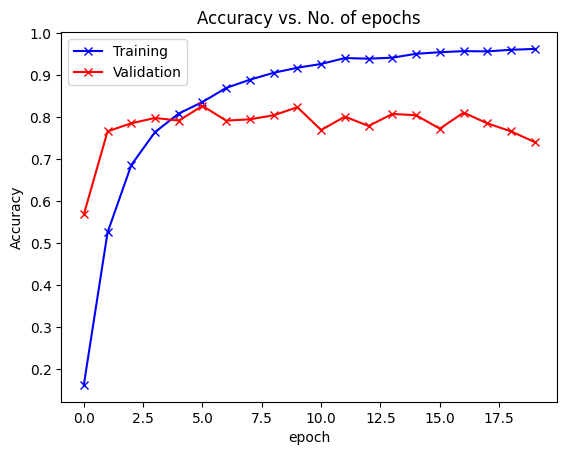

In [88]:
plot_losses_2(history_mobilenetv3_nadam)
plot_accuracies_2(history_mobilenetv3_nadam)

The model with NAdam optimizer perform similar to the model with Adam optimizer. The model is overfitt, as indicated by the loss curve above that gets worst over time.

### Weight Freeze
In this section, the weight of the model will be freezed, except the last classifier layer. The model will be trained using 20 epochs with Adam optimizer 5e-4 learning rate and 1e-3 weight decay parameter.

In [102]:
model_mobilenetv3_freeze = MobileNetV3(len(dataset_imp.classes), freeze_layers=True)
model_mobilenetv3_freeze = to_device(model_mobilenetv3_freeze, device)

In [104]:
history_mobilenetv3_freeze=[]

In [105]:
num_epochs = 20
lr = 5e-4
opt_func = torch.optim.Adam(model_mobilenetv3_freeze.parameters(), lr=lr, weight_decay=1e-3)

In [ ]:
history_mobilenetv3_freeze += fit_2(num_epochs, model_mobilenetv3_freeze,
                             train_loader_imp, val_loader_imp,
                             opt_func)

Model Result:

In [109]:
model_eval = evaluate_2(model_mobilenetv3_freeze, val_loader_imp)

Loss: 0.9704, Acc: 0.8786


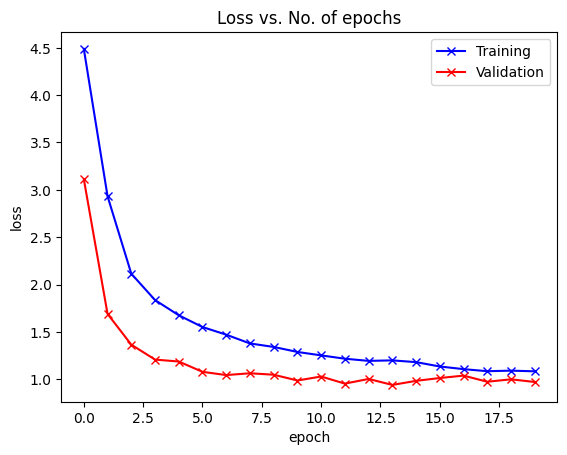

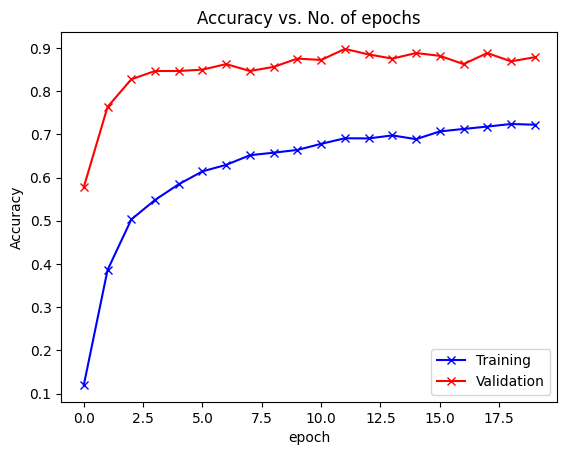

In [108]:
plot_losses_2(history_mobilenetv3_freeze)
plot_accuracies_2(history_mobilenetv3_freeze)

Similar to the ResNet18 model, this method results in the best model, achieving 87.9% validation accuracy. However, as with the ResNet18 model, the training loss curve remains higher than the validation loss curve, indicating that further training may improve the model.

### LR Scheduler

In this method, adjustments are made to the model training process. For the first 10 epochs, the model weights will be frozen except for the last classifier layer, using a learning rate of 1e-3 with the Adam optimizer. For the subsequent 10 epochs, the pretrained model weights will be unfrozen, starting with a learning rate of 1e-3 and employing an Exponential Learning Rate Scheduler with a gamma of 0.8.

In [ ]:
model_mobilenetv3_lr = MobileNetV3(len(dataset_imp.classes), freeze_layers=True)
model_mobilenetv3_lr = to_device(model_mobilenetv3_lr, device)

In [ ]:
history_mobilenetv3_lr=[]

In [ ]:
num_epochs = 10
lr = 1e-3
opt_func = torch.optim.Adam(model_mobilenetv3_lr.parameters(), lr=lr, weight_decay=0)

In [ ]:
history_mobilenetv3_lr += fit_2(num_epochs, model_mobilenetv3_lr,
                             train_loader_imp, val_loader_imp,
                             opt_func, scheduler=None)

In [ ]:
for param in model_mobilenetv3_lr.model.parameters():
    param.requires_grad = True

In [ ]:
num_epochs = 10
lr = 1e-3
opt_func = torch.optim.Adam(model_mobilenetv3_lr.parameters(), lr=lr, weight_decay=0)
for param_group in opt_func.param_groups:
    param_group['initial_lr'] = 1e-3
scheduler = lr_scheduler.ExponentialLR(opt_func, gamma=0.80, last_epoch=10)

In [ ]:
history_mobilenetv3_lr += fit_2(num_epochs, model_mobilenetv3_lr,
                             train_loader_imp, val_loader_imp,
                             opt_func, scheduler=scheduler)

Model Result:

In [ ]:
mobilenetv3_eval = efficiency_test(model_mobilenetv3_lr, val_loader_imp)

 + Number of FLOPs: 0.11G
Loss: 0.6782, Acc: 0.9297


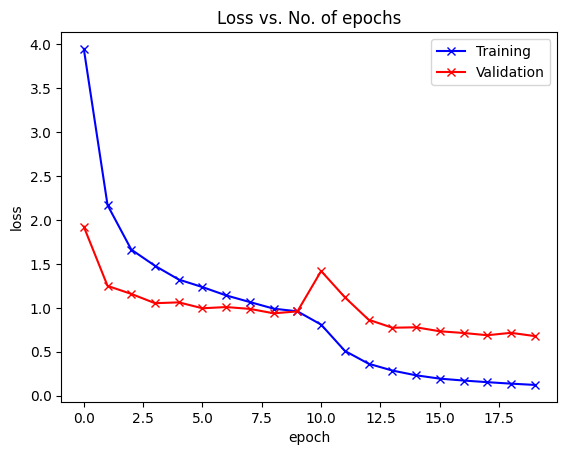

In [ ]:
plot_losses_2(history_mobilenetv3_lr)

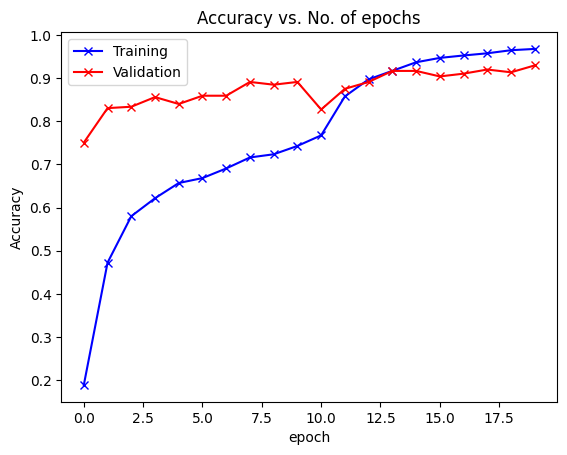

In [ ]:
plot_accuracies_2(history_mobilenetv3_lr)

The graphs above show that the model performs well on both the training and validation data, achieving 93% accuracy on the validation set. This method gives the best result compare to the other two methods. The loss curve shows a similar pattern to the ResNet18 model, where around epoch 10 the model performance decrease, but increase significantly from epoch 11 to 20.

## Experiments Comparison

In this section, the best ResNet18 and MobileNetV3 model will be compared to predict the test dataset.

In [ ]:
model_name = ['ResNet18', 'MobileNetV3']
val_acc = [restnet18_eval[0]['val_acc'], mobilenetv3_eval[0]['val_acc']]
flops = [restnet18_eval[1].item(), mobilenetv3_eval[1].item()]
efficiency = [restnet18_eval[2], mobilenetv3_eval[2]]

df_eval = pd.DataFrame({
    'Accuracy': val_acc,
    'FLOPs': flops,
    'Efficiency': efficiency
}, index=model_name)

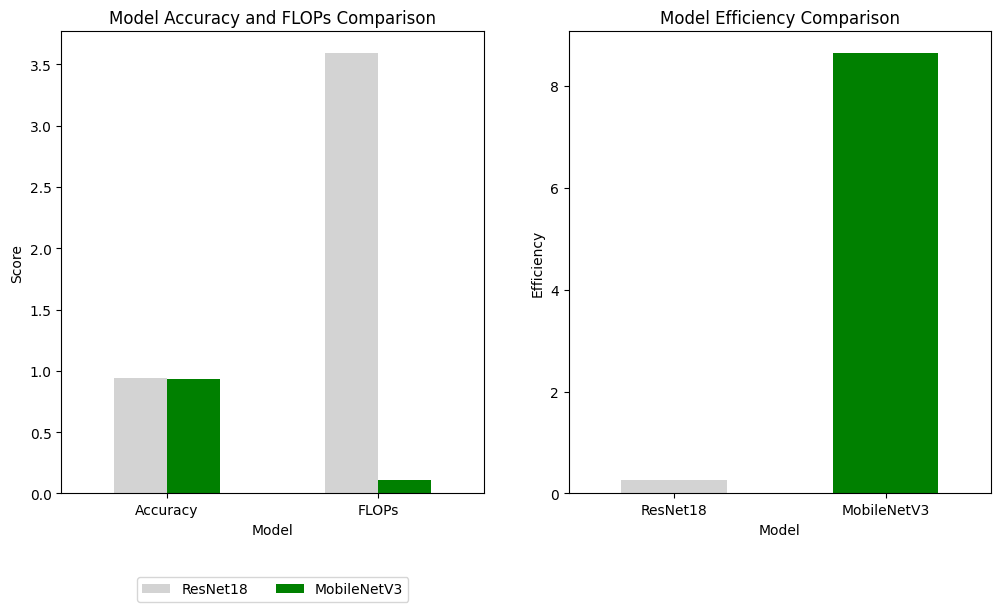

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
df_eval.iloc[:, :2].T.plot(kind='bar', color=['lightgrey', 'green'], ax=axs[0])
axs[0].set_title('Model Accuracy and FLOPs Comparison')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Score')
axs[0].set_xticklabels(df_eval.columns[:2],rotation=0)
axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

df_eval.iloc[:, 2].T.plot(kind='bar', color=['lightgrey', 'green'], ax=axs[1])
axs[1].set_title('Model Efficiency Comparison')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Efficiency')
axs[1].set_xticklabels(df_eval.index,rotation=0)
plt.show()

From the graphs above we could see that there is no big difference of accuracy between the best ResNet18 and MobileNetV3, however MobileNetV3 number of FLOPs is significantly lighter than ResNet18. Therefore when comparing the model efficiency, MobileNetV3 is much higher than ResNet18 model. Thus, it will be used to predict the test data.

# Predict Test Data

In [ ]:
print('Model Evaluation on Test Data')
model_eval = evaluate_2(model_mobilenetv3_lr, test_loader_imp)

# Calculate Number of FLOPs
input = to_device(torch.randn(1, 3, 224, 224), device) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
flops = print_model_parm_flops(model_mobilenetv3_lr, input, detail=False)

model_eff = model_eval['val_acc'] / flops.item()
print('Efficiency:', model_eff)


Model Evaluation on Test Data
Loss: 0.7839, Acc: 0.9346
 + Number of FLOPs: 0.11G
Efficiency: 8.681727188337511


As observed from the result above, the MobileNetV3 model could reach 93% accuracy when predicting the test dataset. This tells us that the model is general enough to predict new dataset. Furthermore, since the model is light, only 0.11G FLOPs, the efficiency of the model is also high, which is 8.68.

In [ ]:
dict_eval['MobileNetV3'] = {
    'Accuracy': model_eval['val_acc'],
    'FLOPs': flops.item(),
    'Efficiency': model_eff
}

In [ ]:
# Folder names as class names
class_folders = os.listdir('/content/drive/MyDrive/CV/animal/dataset/dataset')

# Initialize dictionaries to store false predictions and total images per class
false_predictions = {class_name: 0 for class_name in class_folders}
total_images_per_class = {class_name: 0 for class_name in class_folders}

# Mapping from numeric labels to class names
label_to_class_name = {i: class_name for i, class_name in enumerate(class_folders)}

# Count total images per class
for class_name in class_folders:
    total_images_per_class[class_name] = len(os.listdir(os.path.join('/content/drive/MyDrive/CV/animal/dataset/dataset', class_name)))

all_labels = []
all_preds = []

# Set the model to evaluation mode
model_mobilenetv3_lr.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model_mobilenetv3_lr(images)
        _, predicted = torch.max(outputs, 1)

        # Compare predictions to actual labels
        incorrect = predicted != labels

        # Append predictions and true labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Count false predictions per class
        for label, is_incorrect in zip(labels, incorrect):
            if is_incorrect:
                class_name = label_to_class_name[label.item()]
                false_predictions[class_name] += 1

sorted_false_predictions = sorted(false_predictions.items(), key=lambda item: item[1], reverse=True)

print("Top 5 classes with the highest false predictions:")
for class_id, count in sorted_false_predictions[:5]:
    print(f'Class {class_id}: {count}')

Top 5 classes with the highest false predictions:
Class puma-concolor: 8
Class struthio-camelus: 8
Class enteroctopus-dofleini: 8
Class falco-peregrinus: 7
Class dasypus-novemcinctus: 7


As shown above, are the classes with the highest false prediction. There are no certain type of animals that are always misclassified. This means the model needs to be improved in general to achieve better accuracy.

# Comparison with Baseline Model

In this part, we will compare the best model with the baseline model in order to see the improvement of the model.

In [ ]:
df_evaluation = pd.DataFrame(dict_eval)
df_evaluation

,Base Model,MobileNetV3
Accuracy,0.377083,0.934609
FLOPs,0.689645,0.107652
Efficiency,0.546779,8.681727


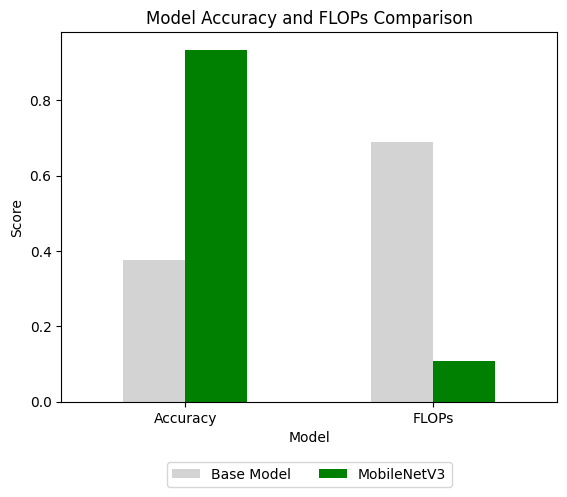

In [ ]:
plt.figure(figsize=(8, 6))
df_evaluation.iloc[:2].plot(kind='bar', color=['lightgrey', 'green'])
plt.title('Model Accuracy and FLOPs Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.show()

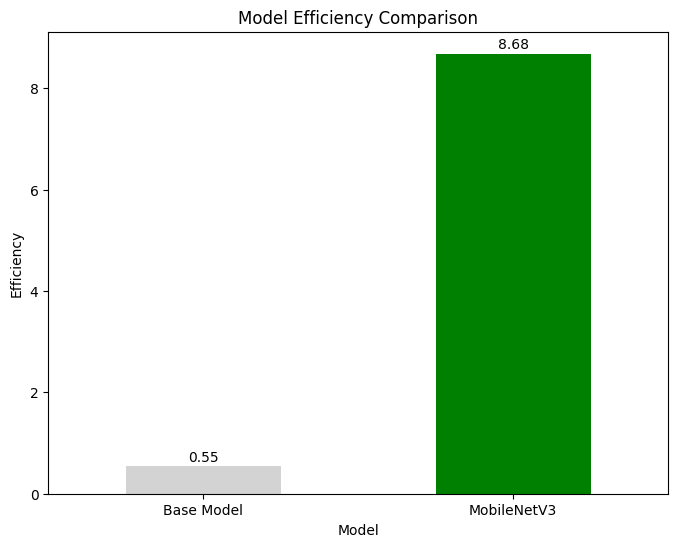

In [ ]:
plt.figure(figsize=(8, 6))
df_evaluation.iloc[2].plot(kind='bar', color=['lightgrey', 'green'])
plt.title('Model Efficiency Comparison')
plt.xlabel('Model')
plt.ylabel('Efficiency')
plt.xticks(rotation=0)
for index, value in enumerate(df_evaluation.iloc[2]):
    plt.text(index, value + 0.1, str(round(value,2)), ha='center')
plt.show()

From the graphs above, it is obvious that the best model has a better performance compare to the baseline model. The best model has a higher accuracy and lower FLOPs. Furthermore, in terms of efficiency the model improve 14.7 times compare to the baseline model.